In [1]:
import allel
import malariagen_data
import dask
import dask.array as da
# silence some dask warnings
dask.config.set(**{'array.slicing.split_large_chunks': True})
from dask.diagnostics.progress import ProgressBar

In [2]:
# Warp frequencies to Dataframe ###
import pandas as pd
#import numpy as np

In [ ]:
# plotting setup
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Plot config 
sns.set_context('paper')
sns.set_style('white')
sns.set_style('ticks')
rcParams = plt.rcParams
base_font_size = 8
rcParams['font.size'] = base_font_size
rcParams['axes.titlesize'] = base_font_size
rcParams['axes.labelsize'] = base_font_size
rcParams['xtick.labelsize'] = base_font_size
rcParams['ytick.labelsize'] = base_font_size

In [3]:
## Importing malariagen data set
ag3 = malariagen_data.Ag3("gs://vo_agam_release/", pre=True)

In [60]:
## Let's select the the sample set from BF and Mali
sample_TM = ["1191-VO-MULTI-OLOUGHLIN-VMF00106", "1191-VO-MULTI-OLOUGHLIN-VMF00140", "AG1000G-BF-A", "AG1000G-BF-B"]
df_samples = ag3.sample_metadata(sample_sets=sample_TM).set_index("sample_id")
df_samples.groupby(['country', 'species', 'year']).size()

country       species                        year
Burkina Faso  arabiensis                     2014     12
                                             2015     88
                                             2016     14
                                             2017      1
              coluzzii                       2012     82
                                             2014    146
                                             2015    183
                                             2016    168
                                             2017    164
              gambiae                        2012     98
                                             2014    170
                                             2015    141
                                             2016    104
                                             2017     37
              intermediate_gambiae_coluzzii  2012      1
Mali          coluzzii                       2014     15
                                      

In [55]:
# select BF samples
bf_samples = df_samples.query('country=="Burkina Faso"')
bf_samples.groupby(['country', 'species', 'year']).size()

country       species                        year
Burkina Faso  arabiensis                     2014     12
                                             2015     88
                                             2016     14
                                             2017      1
              coluzzii                       2012     82
                                             2014    146
                                             2015    183
                                             2016    168
                                             2017    164
              gambiae                        2012     98
                                             2014    170
                                             2015    141
                                             2016    104
                                             2017     37
              intermediate_gambiae_coluzzii  2012      1
dtype: int64

In [95]:
#To access to the genotypes within the 2R chromosomes
chrom2R_gt = ag3.snp_calls(contig="2R", sample_sets= sample_TM)

## let's select BF samples 
BF_samples = df_samples.eval("(country == 'Burkina Faso')").values
#BF_samples 

## To have snp position within the target region in dsx gen
snps_pos = allel.SortedIndex(chrom2R_gt['variant_position'].values)
loc_region = snps_pos.locate_range(48714420,48714720)
loc_region

#To the genomics dataset within the dsx amplicom region and BF_samples
dsx_region = chrom2R_gt.sel(variants=loc_region, samples=BF_samples)
#dsx_region

# To filter the SNP dataset and warp the dataset to GT array
filt = 'gamb_colu_arab'
filt_val = dsx_region[f"variant_filter_pass_{filt}"].values
ampl_gt_filtered = allel.GenotypeDaskArray(dsx_region["call_genotype"][filt_val].data)

In [96]:
## To count the number of alleles 
with ProgressBar():
    ampl_ac = ampl_gt_filtered.count_alleles(max_allele=3).compute()

[########################################] | 100% Completed |  1min 36.6s


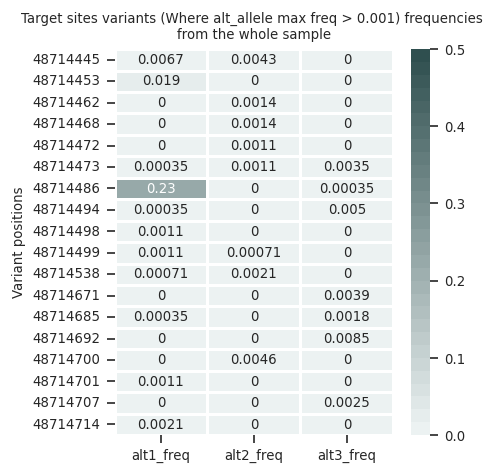

In [97]:
# To get the variants positions within the target region in dsx
is_variant = ampl_ac.is_variant()
pos_df = dsx_region['variant_position'][filt_val][is_variant].compute()
pos = allel.SortedIndex(pos_df["variant_position"].values) 

### Compute the allelic frequencies within the whole sample from Burkina Faso
df_pos = pd.DataFrame(pos, columns=['pos'])
df_ac = pd.DataFrame(ampl_ac[is_variant], columns=['wt_allel', 'alt1_allel', 'alt2_allel', 'alt3_allel'])
df_af = pd.DataFrame(ampl_ac[is_variant].to_frequencies(), columns=['wt_freq', 'alt1_freq', 'alt2_freq', 'alt3_freq'])

## Warp all the df in one df 
freq_df = pd.concat([df_pos, df_ac, df_af], axis=1)
freq_df.to_csv('Dsx_amplicom_SNPs_frequencies_within_the_whole_sample.csv')

## Max_allele frea > 0.001
freq_max = freq_df.query('alt1_freq > 0.001 or alt2_freq > 0.001 or alt3_freq > 0.001 ') 

### plot allele freqs per alt alleles 
fig = plt.figure(figsize=(4,4))

# plot
ax=sns.heatmap(freq_max.iloc[:,[6, 7, 8]], vmin=0,vmax=0.5,cmap=sns.light_palette("darkslategray",n_colors=30),
               yticklabels=freq_max.pos,linewidths=0.8,linecolor="white",annot=True)
ax.set_ylabel("Variant positions")
ax.set_title("Target sites variants (Where alt_allele max freq > 0.001) frequencies \nfrom the whole sample")

fig.tight_layout()
#fig.savefig('plot_dsx_freq', dpi=300, bbox_inches='tight')

In [98]:
## Samples diversity per species 

In [99]:
# Sample cohort per year  (pop per year)
species, year, pops1, pops2 = list(bf_samples.species.unique()), list(bf_samples.year.unique()), {}, {}
for idx in range(len(species)):
    pops1[f"BF_{species[idx]}"] = f'(country == "Burkina Faso") and (species == "{species[idx]}")'
    for idx1 in range (len(year)):
            pops2[f"BF_{species[idx]}_{year[idx1]}"] = f'(country == "Burkina Faso") and (species == "{species[idx]}") and (year == {year[idx1]})'

In [100]:
# Group genotype, and allelle count per pops for each species 
def species_genotype():
    global gt_sp, ac_sp
    gt_sp, ac_sp = {}, {}
    for key in pops1.keys():
        key_gt = chrom2R_gt.sel(variants=loc_region, samples=df_samples.eval(pops1[key]).values)
        key_gt1 = allel.GenotypeDaskArray(key_gt["call_genotype"][filt_val].data)
        gt_sp[key] = allel.GenotypeArray(key_gt1)
        ac_sp[key] = gt_sp[key].count_alleles(max_allele=3)

species_genotype()

In [101]:
## dsx variants allelic freq within An. gambiae ss

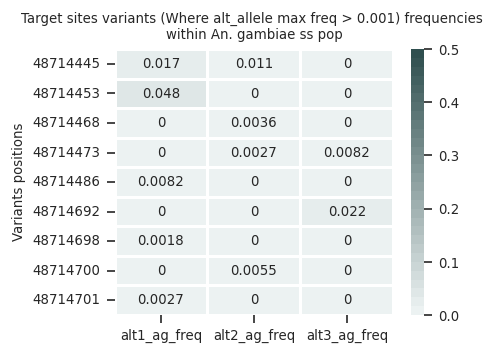

In [111]:
### allelic frequencies  within An. gambiae ss pop 
is_var_ag = ac_sp['BF_gambiae'].is_variant()
var_pos_ag = dsx_region['variant_position'][filt_val][is_variant].compute()

## freq dataframe 
df_ag_pos = pd.DataFrame(var_pos_ag, columns=['pos'])
df_ag_ac = pd.DataFrame(ac_sp['BF_gambiae'][is_variant], columns=['wt_ag_allel', 'alt1_ag_allel', 'alt2_ag_allel', 'alt3_ag_allel'])
df_ag_af = pd.DataFrame(ac_sp['BF_gambiae'][is_variant].to_frequencies(), columns=['wt_ag_freq', 'alt1_ag_freq', 'alt2_ag_freq', 'alt3_ag_freq'])

freq_ag_df = pd.concat([df_ag_pos, df_ag_ac, df_ag_af], axis=1)
freq_ag_df.to_csv('Dsx_amplicom_SNPs_frequencies_within_the_An_gambiae_ss_pop.csv')

## Max_allele frea > 0.001
freq_ag_max = freq_ag_df.query('alt1_ag_freq > 0.001 or alt2_ag_freq > 0.001 or alt3_ag_freq > 0.001 ')

## plot allele freqs per alt alleles 
fig = plt.figure(figsize=(4,3))

# plot
ax=sns.heatmap(freq_ag_max.iloc[:,[6, 7, 8]], vmin=0,vmax=0.5,cmap=sns.light_palette("darkslategray",n_colors=30),
               yticklabels=freq_ag_max.pos,linewidths=0.8,linecolor="white",annot=True)
ax.set_ylabel("Variants positions")
ax.set_title("Target sites variants (Where alt_allele max freq > 0.001) frequencies \nwithin An. gambiae ss pop")

fig.tight_layout()
#fig.savefig('plot_dsx_freq', dpi=300, bbox_inches='tight')

In [103]:
## ## dsx variants allelic freq within An. coluzzi pop 

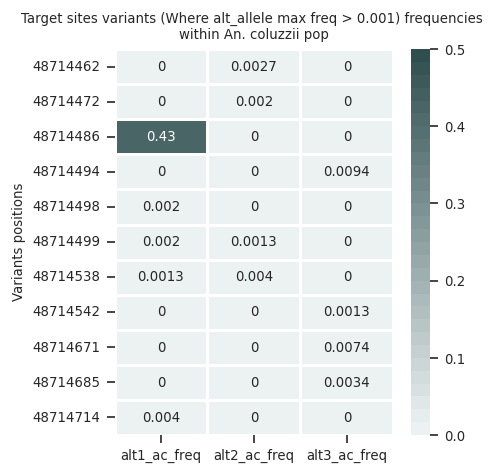

In [114]:
### allelic frequencies  within An. coluzzi pop 
is_var_ac = ac_sp['BF_coluzzii'].is_variant()
var_pos_ac = dsx_region['variant_position'][filt_val][is_variant].compute()

## freq dataframe 
df_ac_pos = pd.DataFrame(var_pos_ac, columns=['pos'])
df_ac_ac = pd.DataFrame(ac_sp['BF_coluzzii'][is_variant], columns=['wt_ac_allel', 'alt1_ac_allel', 'alt2_ac_allel', 'alt3_ac_allel'])
df_ac_af = pd.DataFrame(ac_sp['BF_coluzzii'][is_variant].to_frequencies(), columns=['wt_ac_freq', 'alt1_ac_freq', 'alt2_ac_freq', 'alt3_ac_freq'])

freq_ac_df = pd.concat([df_ac_pos, df_ac_ac, df_ac_af], axis=1)
freq_ac_df.to_csv('Dsx_amplicom_SNPs_frequencies_within_the_An_coluzzii_pop.csv')

## Max_allele frea > 0.001
freq_ac_max = freq_ac_df.query('alt1_ac_freq > 0.001 or alt2_ac_freq > 0.001 or alt3_ac_freq > 0.001 ')

## plot allele freqs per alt alleles 
fig = plt.figure(figsize=(4,4))

# plot
ax=sns.heatmap(freq_ac_max.iloc[:,[6, 7, 8]], vmin=0,vmax=0.5,cmap=sns.light_palette("darkslategray",n_colors=30),
               yticklabels=freq_ac_max.pos,linewidths=0.8,linecolor="white",annot=True)
ax.set_ylabel("Variants positions")
ax.set_title("Target sites variants (Where alt_allele max freq > 0.001) frequencies \nwithin An. coluzzii pop")

fig.tight_layout()
#fig.savefig('plot_dsx_freq', dpi=300, bbox_inches='tight')

In [105]:
### dsx variants allelic freq within An. arabiensis

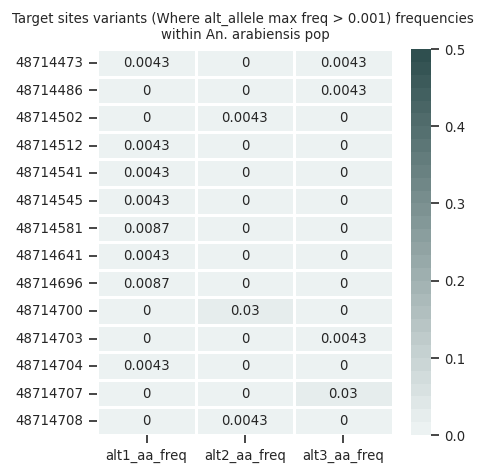

In [115]:
### allelic frequencies  within An. arabiensis pop 
is_var_aa = ac_sp['BF_arabiensis'].is_variant()
var_pos_aa = dsx_region['variant_position'][filt_val][is_variant].compute()

## freq dataframe 
df_aa_pos = pd.DataFrame(var_pos_aa, columns=['pos'])
df_aa_ac = pd.DataFrame(ac_sp['BF_arabiensis'][is_variant], columns=['wt_aa_allel', 'alt1_aa_allel', 'alt2_aa_allel', 'alt3_aa_allel'])
df_aa_af = pd.DataFrame(ac_sp['BF_arabiensis'][is_variant].to_frequencies(), columns=['wt_aa_freq', 'alt1_aa_freq', 'alt2_aa_freq', 'alt3_aa_freq'])

freq_aa_df = pd.concat([df_aa_pos, df_aa_ac, df_aa_af], axis=1)
freq_aa_df.to_csv('Dsx_amplicom_SNPs_frequencies_within_the_An_arabiensis_pop.csv')

## Max_allele frea > 0.001
freq_aa_max = freq_aa_df.query('alt1_aa_freq > 0.001 or alt2_aa_freq > 0.001 or alt3_aa_freq > 0.001 ')

## plot allele freqs per alt alleles 
fig = plt.figure(figsize=(4,4))

# plot
ax=sns.heatmap(freq_aa_max.iloc[:,[6, 7, 8]], vmin=0,vmax=0.5,cmap=sns.light_palette("darkslategray",n_colors=30),
               yticklabels=freq_aa_max.pos,linewidths=0.8,linecolor="white",annot=True)
ax.set_title("Target sites variants (Where alt_allele max freq > 0.001) frequencies \nwithin An. arabiensis pop")

fig.tight_layout()
#fig.savefig('plot_dsx_freq', dpi=300, bbox_inches='tight')

In [116]:
### Plot of dsx variants allelic within all species 

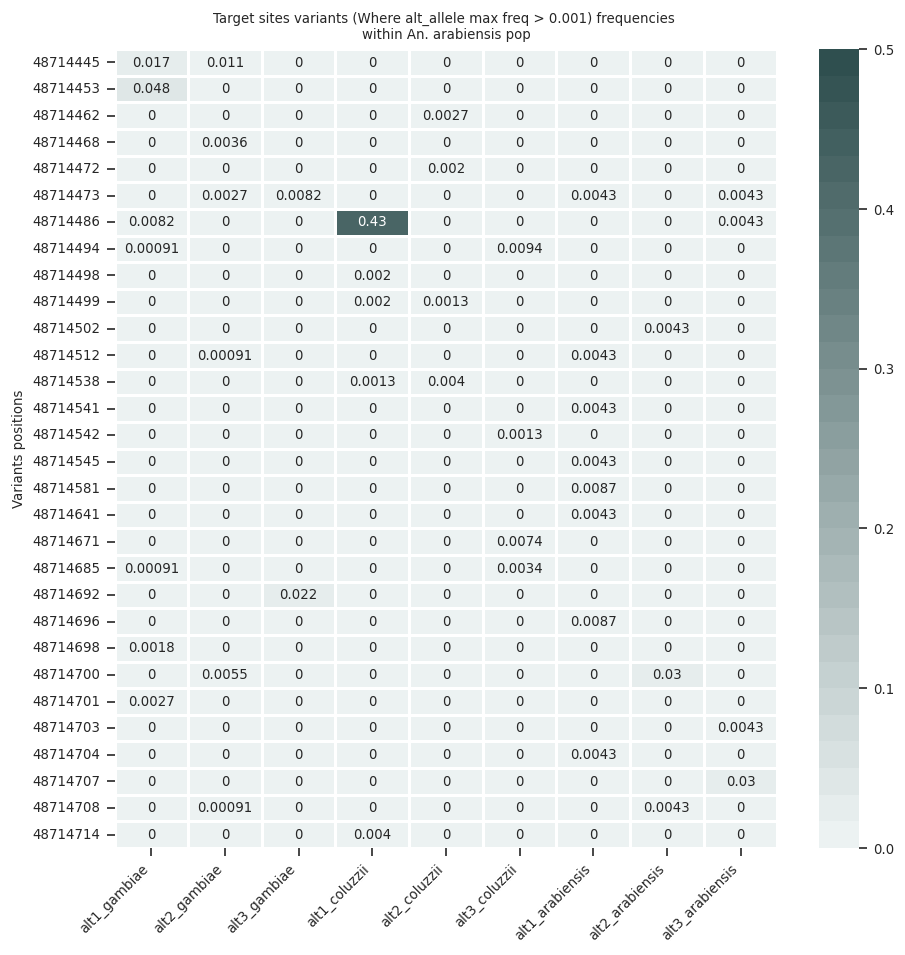

In [108]:
## Freq dataframe of the three species 
freq_sp_df = pd.concat([df_aa_pos, df_ag_af, df_ac_af, df_aa_af], axis=1)
subset = 'alt1_ac_freq > 0.001 or alt2_ac_freq > 0.001 or alt3_ac_freq > 0.001 or alt1_ag_freq > 0.001 or alt2_ag_freq > 0.001 or alt3_ag_freq > 0.001 or alt1_aa_freq > 0.001 or alt2_aa_freq > 0.001 or alt3_aa_freq > 0.001 '
freq_sp_max = freq_sp_df.query(subset)

## plot allele freqs per alt alleles 
fig = plt.figure(figsize=(8,8))
ticks_labels = ['alt1_gambiae', 'alt2_gambiae', 'alt3_gambiae',
               'alt1_coluzzii', 'alt2_coluzzii', 'alt3_coluzzii',
               'alt1_arabiensis', 'alt2_arabiensis', 'alt3_arabiensis']
# plot
ax=sns.heatmap(freq_sp_max.iloc[:,[2,3,4, 6,7,8,10,11,12]], vmin=0,vmax=0.5,cmap=sns.light_palette("darkslategray",n_colors=30),
               yticklabels=freq_sp_max.pos,linewidths=0.8,linecolor="white",annot=True)
ax.set_xticklabels(ticks_labels, rotation = 45, ha = 'right')
ax.set_ylabel("Variants positions")
ax.set_title("Target sites variants (Where alt_allele max freq > 0.001) frequencies \nwithin An. arabiensis pop")

fig.tight_layout()
#fig.savefig('plot_dsx_freq', dpi=300, bbox_inches='tight')